In [1]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import string
#patch_sklearn(verbose=False)
from typing import List
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
import contractions
from gensim.models import Word2Vec
from nltk.stem.snowball import SnowballStemmer 
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [3]:
nltk.download('popular', quiet=True)
nltk.download('universal_tagset', quiet=True)

True

# Logistic Regression

In Natural Language Processing (NLP) the logistic regression is considered as a baseline model, which is used to compare to other models. It is an important tool, with well developed theoretical properties, which is why it has been chosen as one of the first models to be implemented in this task. Here the multinomial logistic regression is used, since there are more than 2 classes (also called a 'soft-max' regression). Each observation is labelled as a class $k$ from a set of $K$ total classes. The assumption is that only one of these classes is correct, that is, any given observation can only belong to one class <a href="#ref">(Jurasky et al)</a>.

## 0. Downloading the Data

In [4]:
df_train = pd.read_csv("ATML2023_reviews_train.csv")
df_test = pd.read_csv("ATML2023_reviews_test.csv")

In [5]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (164000, 8)
Test: (41000, 7)


There are a total of 164000 rows and 8 columns in the train set . There are a total of 41000 rows and 7 columns (excluding the response) in the test set.

## 1. Data Preprocessing

The `'review_title'` and `'review_body'` are combined together. The model performs better when the two columns are combined.

In [6]:
df_train['review_body'] = df_train['review_title'] + ' ' + df_train['review_body']
df_test['review_body'] = df_test['review_title'] + ' ' + df_test['review_body']

NA's and duplicates are dropped and the index is reset in the train set.

In [7]:
df_train = df_train.dropna().drop_duplicates().reset_index(drop=True)

Capital letters are lowered in both data sets.

In [8]:
df_train['review_body'] = df_train['review_body'].apply(lambda x: x.lower())
df_test['review_body'] = df_test['review_body'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [9]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (163975, 8)
Test: (41000, 7)


The resulting shapes are 163975 rows and 8 columns in the train set and a total of 41000 rows and 7 columns (excluding the response) in the test set. 

## 3. Getting text data

Rearranging the data for training.

In [10]:
text_data = df_train[['review_body', 'rating']]
text_data_test=df_test['review_body'] 

##  4. Splitting the data


The training data set is split into test and training sets, to be able to evaluate the model before submitting predictions into Kaggle.

In [11]:
# Split the data into train and test sets
X_train,X_test,Y_train, Y_test = train_test_split(text_data['review_body'], text_data['rating'],test_size=0.2, random_state=977,shuffle=True)

# Print the shapes of the train and test sets
print("Train X set shape:", X_train.shape)
print("Test X set shape:", X_test.shape)
print("Train Y set shape:", Y_train.shape)
print("Test Y set shape:", Y_test.shape)

Train X set shape: (131180,)
Test X set shape: (32795,)
Train Y set shape: (131180,)
Test Y set shape: (32795,)


All data sets are converted to numpy.

In [12]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
text_data_test=text_data_test.to_numpy()

All responses are converted to integers.

In [13]:
Y_train= (np.array([int(label) for label in Y_train])).astype(int)
Y_test= (np.array([int(label) for label in Y_test])).astype(int)

## 5. Natural Language Processing: Text Normalization

Lemmatization is a crucial part of text normalization. The task is to determine whether two words have the same roots, given their apparent differences. For example, the words "sang", "sings", "sung" are all forms of the verb "sing" <a href="#ref">(Jurasky et al.)</a>. The NLTK `WordNetLemmatizer` has been used, which is normally implemented with Position-of-Speech (POS) tags. The lemmatizer has been implemnted within a custom tokenizer function. Stopwords and punctuations have also been removed.

In [14]:
wnl = nltk.stem.WordNetLemmatizer()

In [15]:
# Write your custom tokenizer method here:
stopwords = nltk.corpus.stopwords.words("english")
punctuation=string.punctuation

def custom_tokenizer(text: str):
    if isinstance(text, float) and math.isnan(text):
        return []
    text_tokens = nltk.word_tokenize(text)
    output = []
    for w, pos in nltk.pos_tag(text_tokens, tagset="universal"):
        if pos in ["VERB"]:
            pos = "v"
        elif pos in ["ADJ"]:
            pos = "a"
        elif pos in ["ADV"]:
            pos = "r"
        elif pos in ["NOUN"]:
            pos = "n"
        else:
            pos = "n"

        # Lemmatized form accounting for POS-tag
        l = wnl.lemmatize(w, pos=pos)

        # Filter out stopwords
        if l not in stopwords and punctuation:
            output.append(l)
    return output

## 6.Word embedding

Embeddings are short dense vectors representing words and their semantics. These vectors are short compared to a large corpus vocabulary.  <a href="#ref">(Jurasky et al.)</a>

 ### Bag-of-words (BOW) with Term-frequency Inverse-document-frequency (TF-IDF)


The intuition behind the BOW is litterarily placing words into a conceptual bag in an unorderly fashion. Interest lies in each word's frequency in the document. In TFIDF the frequency of nearby words is incorporated into a function which defines the word meanings. TFIDF results in long vectors with many zeros. <a href="#ref">(Jurasky et al.)</a>

In [15]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=True, min_df=1e-3)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

/Users/user/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
tfidf_train.shape

(131180, 1918)

The dimension of the resulting training set is much larger than that of the original training data. It contains significantly more columns.

## 7. Logistic with Hyper Parameter Tunning

A logistic pipeline is defined for coding convenience. It incorporates the `'custom_tokenizer'` defined above and the actual model.

In [17]:
logistic_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=True, min_df=1e-3, max_df=0.999)),
    ("logistic", LogisticRegression(max_iter=int(1e4)))
])

A small `GridSearchCV` is performed to tune the model. The parameters to be evaluated are defined in `'my_grid'`. The number of splits in `KFold` is 3. 

In [18]:
# Define parameter grid
my_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "logistic__C": [10, 100, 1000],
}

# Define folds
folds = KFold(n_splits=3, shuffle=True, random_state=42)

# Define grid search CV
# tfidf_logistic_cv = GridSearchCV(estimator=logistic_pipe, param_grid=my_grid, scoring="accuracy", cv=folds, n_jobs=-2)

# Run CV
# tfidf_logistic_cv.fit(X_train, Y_train)

The results have been saved and can be loaded below.

In [19]:
best_params_LR= tfidf_logistic_cv.best_params_


In [20]:
best_model_LR = tfidf_logistic_cv.best_estimator_


In [21]:
tfidf_vectorizery_hat = best_model_LR.predict(X_test)


In [22]:
accuracy_LR= accuracy_score(Y_test, tfidf_vectorizery_hat)

In [23]:
with open('grid_search_results_LR.pkl', 'rb') as f:
    # Load the data from the file
    best_params_LR, best_model_LR, accuracy_LR = pickle.load(f)

# Now you can use the loaded data
print("Accuracy score for Logistic Regression:", accuracy_LR)

Accuracy score for Logistic Regression: 0.5755450525994816


The resulting accuracy on the test set is 0.58. Here, the accurracy is defined as

$$
\operatorname{accuracy}(y, \hat{y})=\frac{1}{n_{\text {samples }}} \sum_{i=0}^{n_{\text {samples }}-1} 1\left(\hat{y}_i=y_i\right),
$$

with $1(x)$ being the indicator function.

# KNN Classification

## 0. Downloading the Data

In [2]:
df_train = pd.read_csv("ATML2023_reviews_train.csv")
df_test = pd.read_csv("ATML2023_reviews_test.csv")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (164000, 8)
Test: (41000, 7)


## 1. Data Preprocessing

The `'review_body'` and `'review_title'` are combined into one string. Performance is enhanced by including all information.

In [3]:
df_train['review_body'] = df_train['review_title'] + ' ' + df_train['review_body']
df_test['review_body'] = df_test['review_title'] + ' ' + df_test['review_body']

All NA's and duplicates are dropped from the training dataframe. These will not add anything to the model training and it is best to exclude them.

In [4]:
df_train = df_train.dropna().drop_duplicates().reset_index(drop=True)

All capital letters are lowered.

In [5]:
df_train['review_body'] = df_train['review_body'].apply(lambda x: x.lower())
df_test['review_body'] = df_test['review_body'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [6]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (163975, 8)
Test: (41000, 7)


## 2. Stemming

Stemming is a technique used to obtain the roots of words. This simplifies the machine learning process by reducing words to their most basic meaning. Lemmatization was also tried at this step, however, stemming provided better results <a href="#ref">(Manning et al.)</a>. This might be due to the fact that the dataset is very large. Here, the Snowball stemmer is used for the English language. Snowball is a small string processing language for creating stemming algorithms for use in Information Retrieval.

In [7]:
snowstem = SnowballStemmer("english")

A custom `stemming_tokenizer` is defined to preprocess the data efficiently. The tokenizer includes:
- an expansion of contracted words (such as won't, haven't, etc)
- the nltk tokenizer
- a removal of stopwords, which do not bring any significant meaning to the text (nltk stopwords)
- removal of punctuation
- stemming

In [8]:
stopwords = nltk.corpus.stopwords.words("english")

def stemming_tokenizer(text: str):
    
    # Expanding contractions:
    expanded_words = []
    for word in text.split():
        expanded_words.append(contractions.fix(word)) 
        expanded_text = ' '.join(expanded_words)
    
    # Tokenizing:
    text_tokens = nltk.word_tokenize(expanded_text)

    # Removing Stopwords:
    filtered_text = [w for w in text_tokens if not w.lower() in stopwords]
    
    
# Removing punctuation:
    no_punctuation = list(filter(lambda filtered_text: filtered_text not in string.punctuation, filtered_text))
    # Stemming (capitals removed here)
    text_stems = [snowstem.stem(word) for word in no_punctuation]
    
    return text_stems

The training data set is passed through the `stemming_tokenizer`:

In [9]:
corpus_stemming = df_train.review_body.apply(lambda row: stemming_tokenizer(row))

All integers in the test data set are converted to strings and then passed through the `'stemming_tokenizer'`.

In [10]:
# Converting any integers in the test corpus to str:
df_test['review_body'] = (df_test['review_body']).apply(str)
test_stemming = df_test.review_body.apply(lambda row: stemming_tokenizer(row))

## 3. Word2Vec

`Word2Vec` is a common method of generating word embeddings; a method to convert words into vectors or numerical representations. Each word is mapped to a vector and each vector is learned through a machine learning model. The model tries to learn word contexts, similarities, dissimilarities, semantic relationships between words, etc.

Here, the Skip-Gram model is used, which is a neural network with one hidden layer. It tries to predict the probability of a word being present, when an input word it present. In essence, it tries to learn word contexts for a given word of input<a href="#ref">(Towards Data Science, 2021)</a>.

In [11]:
vector_size = 200

w2v_stem_model = Word2Vec(
    corpus_stemming,
    alpha=0.1,
    vector_size=vector_size,
    min_count=3,  
    sg = 1, # skip-gram
    window=50,   
)   

print(w2v_stem_model)

Word2Vec<vocab=16348, vector_size=200, alpha=0.1>


A quick, manual hyperparameter tuning was performed (not shown here) and a large vector size  and large window was found to perform better. 

In [12]:
vocab_stemming = w2v_stem_model.wv.key_to_index
len(vocab_stemming)
stem_words = set(w2v_stem_model.wv.key_to_index)

In [13]:
corpus_stemming = np.array([np.array([w2v_stem_model.wv[i] for i in ls if i in stem_words])
                         for ls in corpus_stemming])

/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_99291/1912696036.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corpus_stemming = np.array([np.array([w2v_stem_model.wv[i] for i in ls if i in stem_words])


Vectors are averaged to be consistent in terms of feature number and to be able to pass them into the machine learning model. Now each vector will  be of the same length, with the same number of features.

In [14]:
text_vect_avg = []
for v in corpus_stemming:
    if v.size:
        text_vect_avg.append(v.mean(axis=0))
    else:
        text_vect_avg.append(np.zeros(vector_size, dtype=float)) 
        
        
corpus_stemming = text_vect_avg

A dataframe is created with the new vectors:

In [15]:
corpus_stemming = pd.DataFrame(corpus_stemming)
corpus_stemming.columns = ['S_Element_' + str(i+1) for i in range(0, corpus_stemming.shape[1])]

Repeating the same process with the test data:

In [16]:
vector_size = 200

w2v_stem_test = Word2Vec(
    test_stemming,
    alpha=0.1,
    vector_size=vector_size,
    min_count=3,  
    sg = 1,    
    window=50,   
)   

print(w2v_stem_test)

Word2Vec<vocab=8610, vector_size=200, alpha=0.1>


In [17]:
vocab_test = w2v_stem_test.wv.key_to_index
len(vocab_test)
stem_words_test = set(w2v_stem_test.wv.key_to_index)

In [18]:
test_stemming = np.array([np.array([w2v_stem_test.wv[i] for i in ls if i in stem_words_test])
                         for ls in test_stemming])

/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_99291/2231021143.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_stemming = np.array([np.array([w2v_stem_test.wv[i] for i in ls if i in stem_words_test])


In [19]:
text_vect_avg = []
for v in test_stemming:
    if v.size:
        text_vect_avg.append(v.mean(axis=0))
    else:
        text_vect_avg.append(np.zeros(vector_size, dtype=float)) 
        
        
test_stemming = text_vect_avg

In [20]:
test_stemming = pd.DataFrame(test_stemming)
test_stemming.columns = ['S_Element_' + str(i+1) for i in range(0, test_stemming.shape[1])]

##  4. Splitting the Data

The training dataset needs to be further split into test and training in order to be able to estimate the accuracy of the model.

In [21]:
df_train['rating'] = (np.array([int(label) for label in df_train['rating']])).astype(int)

The response variable `'rating'` takes on 5 unique values, which are 1 through 5. Here, one is removed from each rating to make the variable take on the values 0 to 4 (consistent with python language inputs).

In [22]:
df_train['rating'] = df_train['rating'] - 1

In [23]:
# Split the data into train and test sets
X_train,X_test,Y_train, Y_test = train_test_split(corpus_stemming, df_train['rating'],test_size=0.2, random_state=977,shuffle=True)

# Print the shapes of the train and test sets
print("Train X set shape:", X_train.shape)
print("Test X set shape:", X_test.shape)
print("Train Y set shape:", Y_train.shape)
print("Test Y set shape:", Y_test.shape)

Train X set shape: (131180, 200)
Test X set shape: (32795, 200)
Train Y set shape: (131180,)
Test Y set shape: (32795,)


## 7. KNN with Hyper Parameter Tunning

K-NearestNeigbbors is one of the most simple non-parametric Machine Learning algorithms. It can be used both in regression and classification tasks. In classification, a text is classified based on the classification of its $k$ nearest neighbors. When $k$ is equal to 1, classification will be based on the text which is most similar to itself. The KNN algorithm calculates the distance between a data point and all other data points and assigns a class similar to the $k$ closest datapoints  <a href="#ref">(Kaggle, 2020)</a> .

Here, $k$ is chosen to be 5 to perform a first trial. The model is fit on the training set.

In [24]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, Y_train)

KNeighborsClassifier()

In [47]:
print('Stemmed KNN Train Accuracy %s' % knn_model.score(X_train, Y_train)) 

Stemmed KNN Train Accuracy 0.611335569446562


The `score` method returns the mean accuracy on the given test data and labels. 

Now a GridSearchCV will be performed to find the best number of nearest neighbors. 

In [68]:
# parameters = {"n_neighbors": range(5, 200, 5)}
# KNN_cv = GridSearchCV(KNeighborsClassifier(), parameters, refit = True, scoring='accuracy')
# KNN_cv.fit(X_train, Y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 200, 5)}, scoring='accuracy')

In [1]:
# joblib.dump(KNN_cv.best_estimator_, "best_est_KNN.pkl", compress=1)
# joblib.dump(KNN_cv.best_params_, "best_params_KNN.pkl", compress=1)

In [38]:
KNN_cv = joblib.load("best_est_KNN.pkl")

In [39]:
KNN_cv_param = joblib.load("best_params_KNN.pkl")
KNN_cv_param 

{'n_neighbors': 145}

The best parameters resulted to be 145 neighbors. The model will now be used to predict the class of the test set (which is part of the training data set and for which we know the results).

In [72]:
KNN_vector_hat = KNN_cv.predict(X_test)

In [73]:
KNN_vector_hat

array([0, 3, 1, ..., 0, 4, 4])

In [74]:
accuracy_KNN= accuracy_score(Y_test, KNN_vector_hat)
accuracy_KNN

0.4683030949839915

Strangely, the accuracy of the best parameter from the GridSearchCV is less than that with a random hyperparameter of 5. The accuracy score shows the fraction of the correctly prredicted responses. The result is worse probably due to overfitting in the model where $k=5$, since there is a probability of overfitting for a KNN model with small $k$. In that case, the model will not generalize well to new data as it follows the noise rather than the underlying trend.

#### Confusion matrix

In [25]:
# Get the predicted labels
Y_pred_KNN_1 = knn_model.predict(X_train)

In [26]:
# Create the confusion matrix
conf_matrix_KNN_1 = confusion_matrix(Y_train, Y_pred_KNN_1)

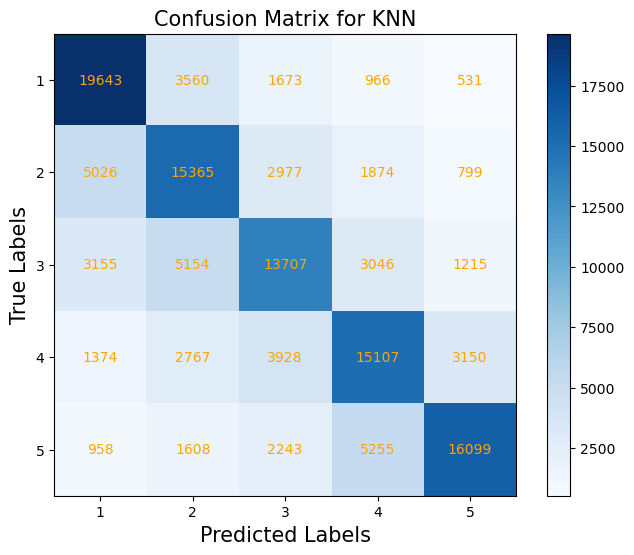

In [29]:
num_classes = 5

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_KNN_1, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=15)
plt.ylabel('True Labels', fontsize=15)
# Replace x-axis and y-axis ticks
ticks = np.arange(0, num_classes)
labels = [str(i) for i in range(1, num_classes+1)]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        try:
            plt.text(j, i, conf_matrix_KNN_1[i, j], ha='center', va='center', color='orange')
        except IndexError:
            pass
plt.show()

The confusion matrix with the KNN model set to $k=5$ does a very nice job at predicting the training set. However, this the the result of overfitting on the training set.

Plotting the confusion matrix using the parameters from the GridSearchCV:

In [46]:
# Get the predicted labels
Y_pred_KNN = KNN_cv.predict(X_train)

In [47]:
# Create the confusion matrix
conf_matrix_KNN = confusion_matrix(Y_train, Y_pred_KNN)

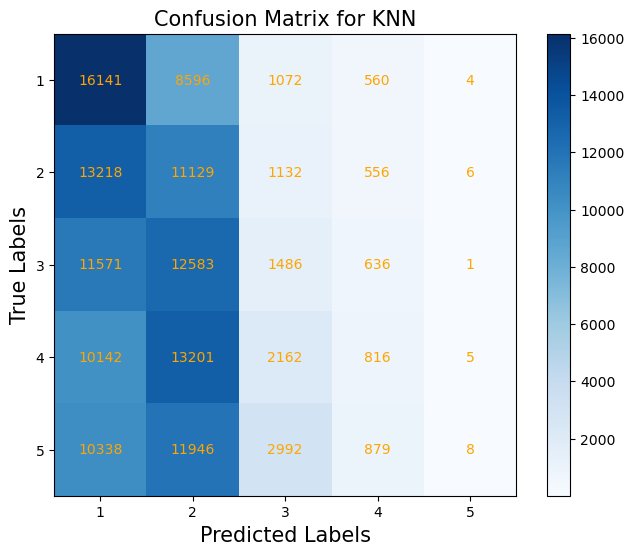

In [48]:
num_classes = 5

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_KNN, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=15)
plt.ylabel('True Labels', fontsize=15)
# Replace x-axis and y-axis ticks
ticks = np.arange(0, num_classes)
labels = [str(i) for i in range(1, num_classes+1)]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        try:
            plt.text(j, i, conf_matrix_KNN[i, j], ha='center', va='center', color='orange')
        except IndexError:
            pass
plt.show()

From the confusion matrix, we can see that the model is only classifying the first 2 classes when k=145 (the result form GridSearchCV). It fails to classify the rest of the classes. This model is now dropped and other more impactful models are considered for further analysis.

<h2 id="ref">References</h2>

1. Manning, C, Raghavan, P & Schutze, H, *Introduction to Information Retrieval* , Cambridge University Press, 2008. https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

2. Towards Data Science 2021, *Word2Vec Explained*, viewed 6 May 2023. 
https://towardsdatascience.com/word2vec-explained-49c52b4ccb71

3. Medium 2021, *Classification Using Word2Vec*, viewed 6 May 2023. 
https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

4. Kaggle 2020, *KNN Classifier Tutorial*, viewed 6 May 2023.
https://www.kaggle.com/code/prashant111/knn-classifier-tutorial

5. Jurafsky, D., James H. M. (2023). Speech and Language Processing (3rd ed. draft), available <a href="https://web.stanford.edu/~jurafsky/slp3/">here.</a>
